# **WE 2.2.3: Request T369639 - Copy without 500 page filter**

(This notebook: Wikipedias in Incubator)

**[[Request] Distributions of project activity on Wikimedia Incubator](https://phabricator.wikimedia.org/T369639)**

* Count of edits in ns0 & rest of the namespaces
* Count of pages created in ns0 & rest of namespaces
* Count of editors with at least 1 edit
* Count editors with at least 5 edits

For all the distributions, it would be helpful to have the distributions for last 1 year and 6 months

In [ ]:
library(tidyverse)
library(here)
library(ggrepel)
library(jsonlite)
library(reticulate)
library(gridExtra)

In [2]:
## Run all wrangling notebooks for up-to-date data
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute 02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case wrangle_final.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

# Prep

In [3]:
## ggplot themes ---------

my_theme <- function(){ 
        
    theme(axis.text.y=element_blank(), 
          axis.text.x=element_text(size=13), 
          plot.subtitle=element_text(size=12, hjust=0.5),
          axis.title=element_text(size=15), 
          plot.title=element_text(size=22, hjust=0.5)) 
}

**Run queries**

In [4]:
# Prep to be able to run spark queries using reticulate package
# per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')

In [5]:
# Query monthly page creation data  
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_pagecreation_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfpm_import <- wmfdata$spark$run(sql_string)

In [6]:
# Query monthly edits data  
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_edits_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfe_import <- wmfdata$spark$run(sql_string)

In [7]:
# Query monthly editors data 
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_editors_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfme_import <- wmfdata$spark$run(sql_string)

In [8]:
# Query monthly editors' edits data 
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_editor_edits_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfmee_import <- wmfdata$spark$run(sql_string)

**Load list of test Wikipedias**

In [9]:
# Load project list
projs <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F) %>%
 select(prefix, language_name, canonical_status, `test-host`, project) %>%
 filter(grepl("test", `test-host`), project!="Wikiversity", project!="Wikisource" ) %>% # filter for only test wikis in Incubator
 mutate(prefix_copy = prefix) %>%
 separate(prefix_copy, into=c("project_abbr", "language_code"), sep="/")

# Filter for Wikipedias
projs <- projs %>% filter(project=="Wikipedia")
nrow(projs)

[1] 738

**Join**

In [10]:
dfe <- dfe_import %>% select(prefix, year, month, page_namespace, edits_count) %>% inner_join(., projs, by="prefix")
dfpm <- dfpm_import %>% select(prefix, year, month, page_namespace, page_creation_count) %>% inner_join(., projs, by="prefix")
dfmee <- dfmee_import %>% select(prefix, event_user_text, year, month, edits_count) %>% inner_join(., projs, by="prefix")

# Count of edits in ns0 & rest of the namespaces


**Edits in namespace 0**

In [11]:
# Filter for namespace 0, then aggregate namespaces
dfe <- dfe %>%
 filter(page_namespace==0) %>%
 dplyr::group_by(prefix, year, month) %>%
 dplyr::summarise(edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'prefix', 'year'. You can override using
the `.groups` argument.


In [12]:
# Define edit_dt
dfe <- dfe %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [13]:
# Filter for past year & sum
dfe_past_year <- dfe %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, edits_count) %>%
 spread(., key="edit_dt", value="edits_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="edits_count", `2023-07-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(edits_count = replace_na(edits_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfe_past_6m <- dfe %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, edits_count) %>%
 spread(., key="edit_dt", value="edits_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="edits_count", `2024-01-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(edits_count = replace_na(edits_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

In [14]:
# Create function: buckets 
f1 <- function(df) {
   
    df <- df %>%
     mutate(buckets4 = factor(
                             ifelse(sum_edits_count>0 & sum_edits_count<=10, "1-10",
                                 ifelse(sum_edits_count>10 & sum_edits_count<=100, "11-100",
                                        ifelse(sum_edits_count>100 & sum_edits_count<=500, "101-500",
                                               ifelse(sum_edits_count>500, "501+", 0)))), levels = c("1-10", "11-100", "101-500", "501+"))) %>%
     mutate(buckets5 = factor(
                             ifelse(sum_edits_count>0 & sum_edits_count<=10, "1-10",
                                         ifelse(sum_edits_count>10 & sum_edits_count<=100, "11-100",
                                                ifelse(sum_edits_count>100 & sum_edits_count<=500, "101-500",
                                                       ifelse(sum_edits_count>500 & sum_edits_count<=1000, "501-1000",
                                                              ifelse(sum_edits_count>1000, "1001+",0))))), levels = c("1-10", "11-100", "101-500", "501-1000", "1001+")))
    }

# Apply function: buckets 
dfe_past_year <- f1(dfe_past_year)
dfe_past_6m <- f1(dfe_past_year)

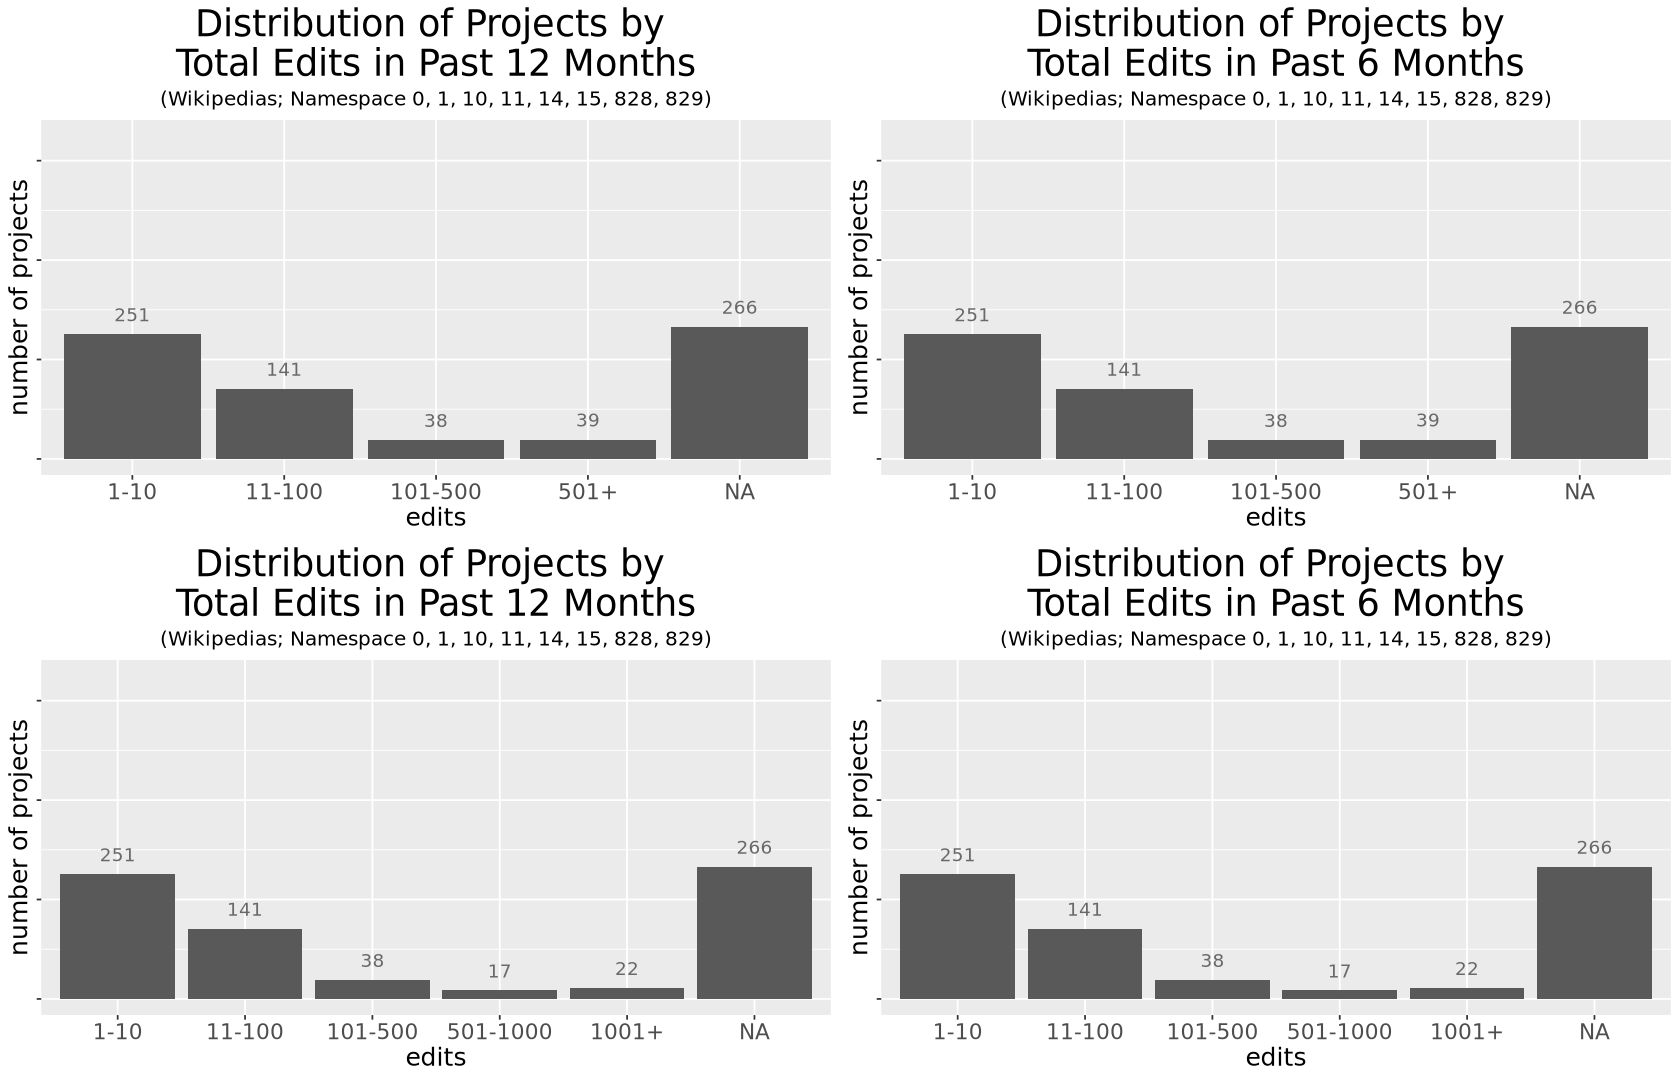

In [15]:
# Plots: total edits past 12 months

p1_4bin <- dfe_past_year %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

p1_5bin <- dfe_past_year %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

# Plots: total edits past 6 months

p2_4bin <- dfe_past_6m %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

p2_5bin <- dfe_past_6m %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=9)
gridExtra::grid.arrange(p1_4bin, p2_4bin, p1_5bin, p2_5bin, ncol = 2) 

**Edits in namespaces 0, 1, 10, 11, 14, 15, 828, 829**

In [16]:
# Aggregate namespaces
dfe <- dfe_import %>%
 dplyr::group_by(prefix, year, month) %>%
 dplyr::summarise(edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'prefix', 'year'. You can override using
the `.groups` argument.


In [17]:
# Define edit_dt
dfe <- dfe %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [18]:
# Filter for past year & sum
dfe_past_year <- dfe %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, edits_count) %>%
 spread(., key="edit_dt", value="edits_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="edits_count", `2023-07-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(edits_count = replace_na(edits_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfe_past_6m <- dfe %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, edits_count) %>%
 spread(., key="edit_dt", value="edits_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="edits_count", `2024-01-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(edits_count = replace_na(edits_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

In [19]:
# Buckets: edits for past 12 months

dfe_past_year$buckets4 <- NA
dfe_past_year$buckets4[dfe_past_year$sum_edits_count>0 & dfe_past_year$sum_edits_count<=10] <- "1-10"
dfe_past_year$buckets4[dfe_past_year$sum_edits_count>10 & dfe_past_year$sum_edits_count<=100] <- "11-100"
dfe_past_year$buckets4[dfe_past_year$sum_edits_count>100 & dfe_past_year$sum_edits_count<=500] <- "101-500"
dfe_past_year$buckets4[dfe_past_year$sum_edits_count>500] <- "501+"
dfe_past_year$buckets4 <- factor(dfe_past_year$buckets4,
                                levels = c("1-10", "11-100", "101-1000", "501+"))

dfe_past_year$buckets5 <- NA
dfe_past_year$buckets5[dfe_past_year$sum_edits_count>0 & dfe_past_year$sum_edits_count<=10] <- "1-10"
dfe_past_year$buckets5[dfe_past_year$sum_edits_count>10 & dfe_past_year$sum_edits_count<=100] <- "11-100"
dfe_past_year$buckets5[dfe_past_year$sum_edits_count>100 & dfe_past_year$sum_edits_count<=500] <- "101-500"
dfe_past_year$buckets5[dfe_past_year$sum_edits_count>500 & dfe_past_year$sum_edits_count<=1000] <- "501-1000"
dfe_past_year$buckets5[dfe_past_year$sum_edits_count>1000] <- "1001+"
dfe_past_year$buckets5 <- factor(dfe_past_year$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))


# Buckets: edits for past 6 months

dfe_past_6m$buckets4 <- NA
dfe_past_6m$buckets4[dfe_past_6m$sum_edits_count>0 & dfe_past_6m$sum_edits_count<=10] <- "1-10"
dfe_past_6m$buckets4[dfe_past_6m$sum_edits_count>10 & dfe_past_6m$sum_edits_count<=100] <- "11-100"
dfe_past_6m$buckets4[dfe_past_6m$sum_edits_count>100 & dfe_past_6m$sum_edits_count<=500] <- "101-500"
dfe_past_6m$buckets4[dfe_past_6m$sum_edits_count>500] <- "501+"
dfe_past_6m$buckets4 <- factor(dfe_past_6m$buckets4,
                                levels = c("1-10", "11-100", "101-500", "501+"))

dfe_past_6m$buckets5 <- NA
dfe_past_6m$buckets5[dfe_past_6m$sum_edits_count>0 & dfe_past_6m$sum_edits_count<=10] <- "1-10"
dfe_past_6m$buckets5[dfe_past_6m$sum_edits_count>10 & dfe_past_6m$sum_edits_count<=100] <- "11-100"
dfe_past_6m$buckets5[dfe_past_6m$sum_edits_count>100 & dfe_past_6m$sum_edits_count<=500] <- "101-500"
dfe_past_6m$buckets5[dfe_past_6m$sum_edits_count>500 & dfe_past_6m$sum_edits_count<=1000] <- "501-1000"
dfe_past_6m$buckets5[dfe_past_6m$sum_edits_count>1000] <- "1001+"
dfe_past_6m$buckets5 <- factor(dfe_past_6m$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


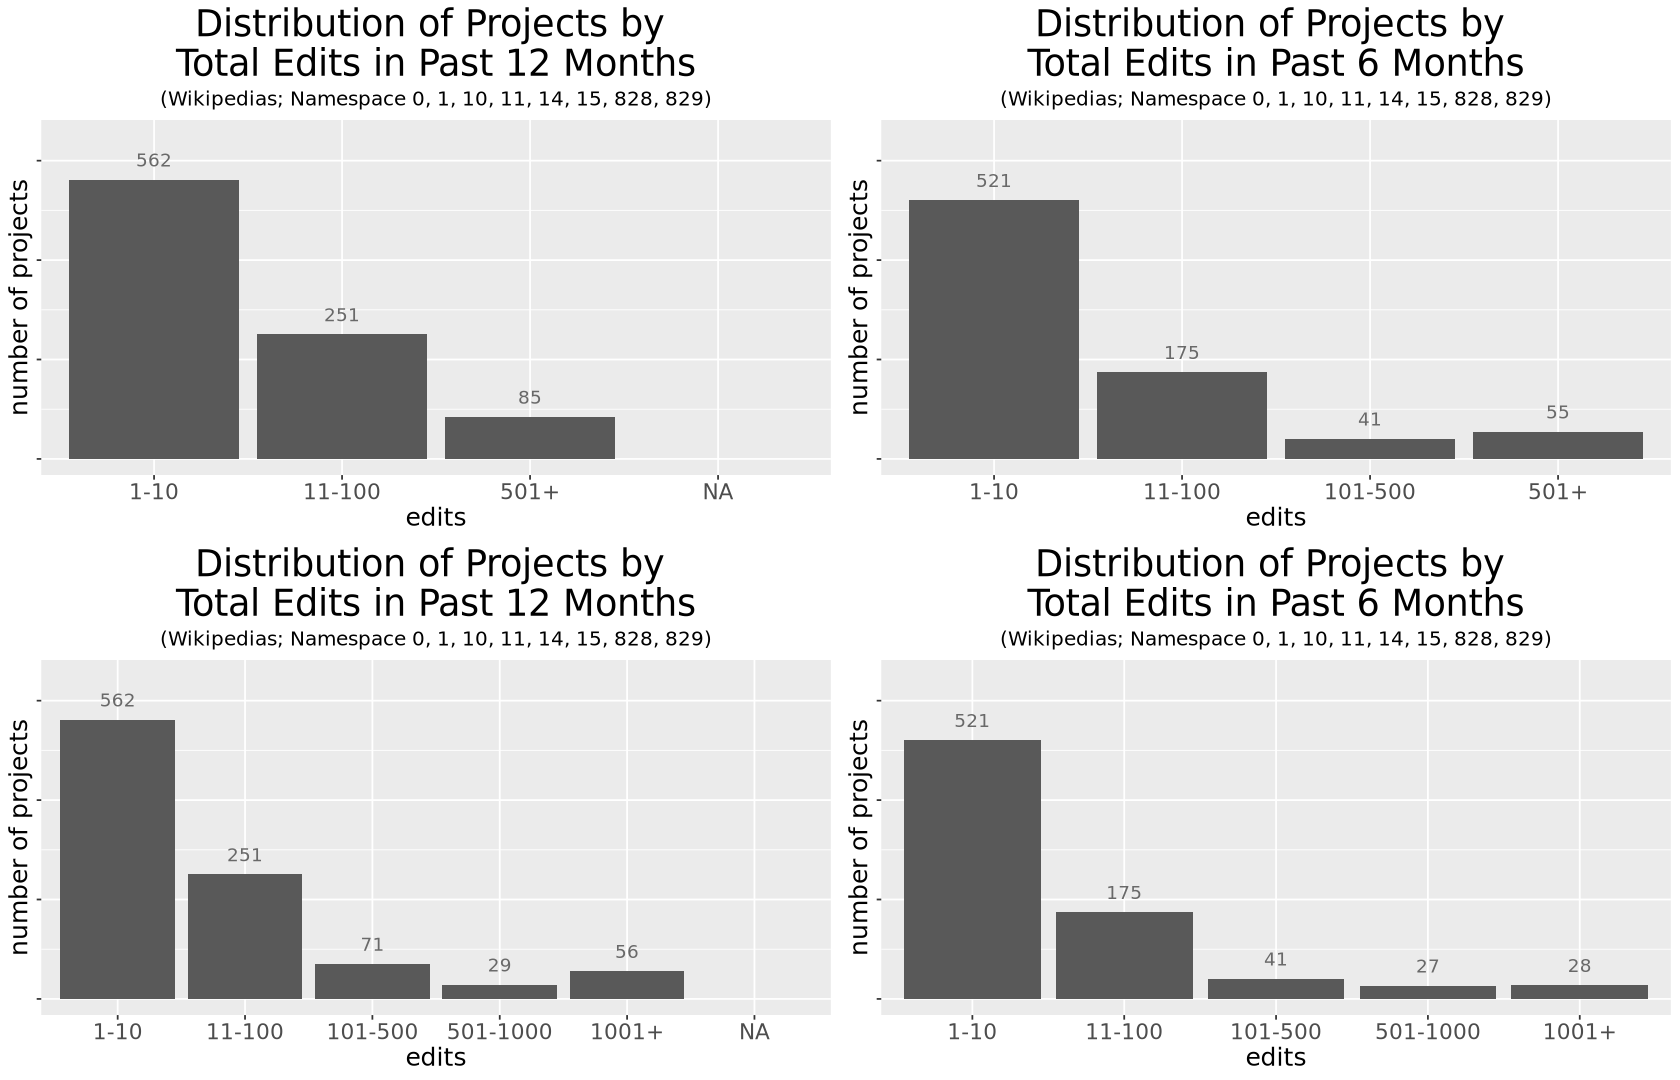

In [20]:
# Plots: total edits past 12 months

p1_4bin <- dfe_past_year %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
  theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

p1_5bin <- dfe_past_year %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
  theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

# Plots: total edits past 6 months

p2_4bin <- dfe_past_6m %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)

p2_5bin <- dfe_past_6m %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "DimGray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("edits") + ylab("number of projects") +
 ylim(0,650)


# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=9)
gridExtra::grid.arrange(p1_4bin, p2_4bin, p1_5bin, p2_5bin, ncol = 2) 

# Count of pages created in ns0 & rest of namespaces

**New page creation in namespace 0**

In [21]:
# Filter for namespace 0, then aggregate namespaces
dfpm <- dfpm_import %>%
 filter(page_namespace==0) %>%
 dplyr::group_by(prefix, year, month) %>%
 dplyr::summarise(page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'prefix', 'year'. You can override using
the `.groups` argument.


In [22]:
# Define edit_dt
dfpm <- dfpm %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [23]:
# Filter for past year & sum
dfpm_past_year <- dfpm %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, page_creation_count) %>%
 spread(., key="edit_dt", value="page_creation_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="page_creation_count", `2023-07-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(page_creation_count = replace_na(page_creation_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfpm_past_6m <- dfpm %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, page_creation_count) %>%
 spread(., key="edit_dt", value="page_creation_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="page_creation_count", `2024-01-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(page_creation_count = replace_na(page_creation_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

In [24]:
# Buckets: edits past 12 months
dfpm_past_year$buckets4 <- NA
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>0 & dfpm_past_year$sum_page_creation_count<=10] <- "1-10"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>10 & dfpm_past_year$sum_page_creation_count<=100] <- "11-100"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>100 & dfpm_past_year$sum_page_creation_count<=500] <- "101-500"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>500] <- "501+"
dfpm_past_year$buckets4 <- factor(dfpm_past_year$buckets4,
                                levels = c("1-10", "11-100", "101-500", "501+"))

dfpm_past_year$buckets5 <- NA
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>0 & dfpm_past_year$sum_page_creation_count<=10] <- "1-10"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>10 & dfpm_past_year$sum_page_creation_count<=100] <- "11-100"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>100 & dfpm_past_year$sum_page_creation_count<=500] <- "101-500"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>500 & dfpm_past_year$sum_page_creation_count<=1000] <- "501-1000"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>1000] <- "1001+"
dfpm_past_year$buckets5 <- factor(dfpm_past_year$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))


# Buckets: edits past 6 months
dfpm_past_6m$buckets4 <- NA
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>0 & dfpm_past_6m$sum_page_creation_count<=10] <- "1-10"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>10 & dfpm_past_6m$sum_page_creation_count<=100] <- "11-100"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>100 & dfpm_past_6m$sum_page_creation_count<=500] <- "101-500"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>500] <- "501+"
dfpm_past_6m$buckets4 <- factor(dfpm_past_6m$buckets4,
                                levels = c("1-10", "11-100", "101-500", "501+"))

dfpm_past_6m$buckets5 <- NA
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>0 & dfpm_past_6m$sum_page_creation_count<=10] <- "1-10"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>10 & dfpm_past_6m$sum_page_creation_count<=100] <- "11-100"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>100 & dfpm_past_6m$sum_page_creation_count<=500] <- "101-500"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>500 & dfpm_past_6m$sum_page_creation_count<=1000] <- "501-1000"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>1000] <- "1001+"
dfpm_past_6m$buckets5 <- factor(dfpm_past_6m$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


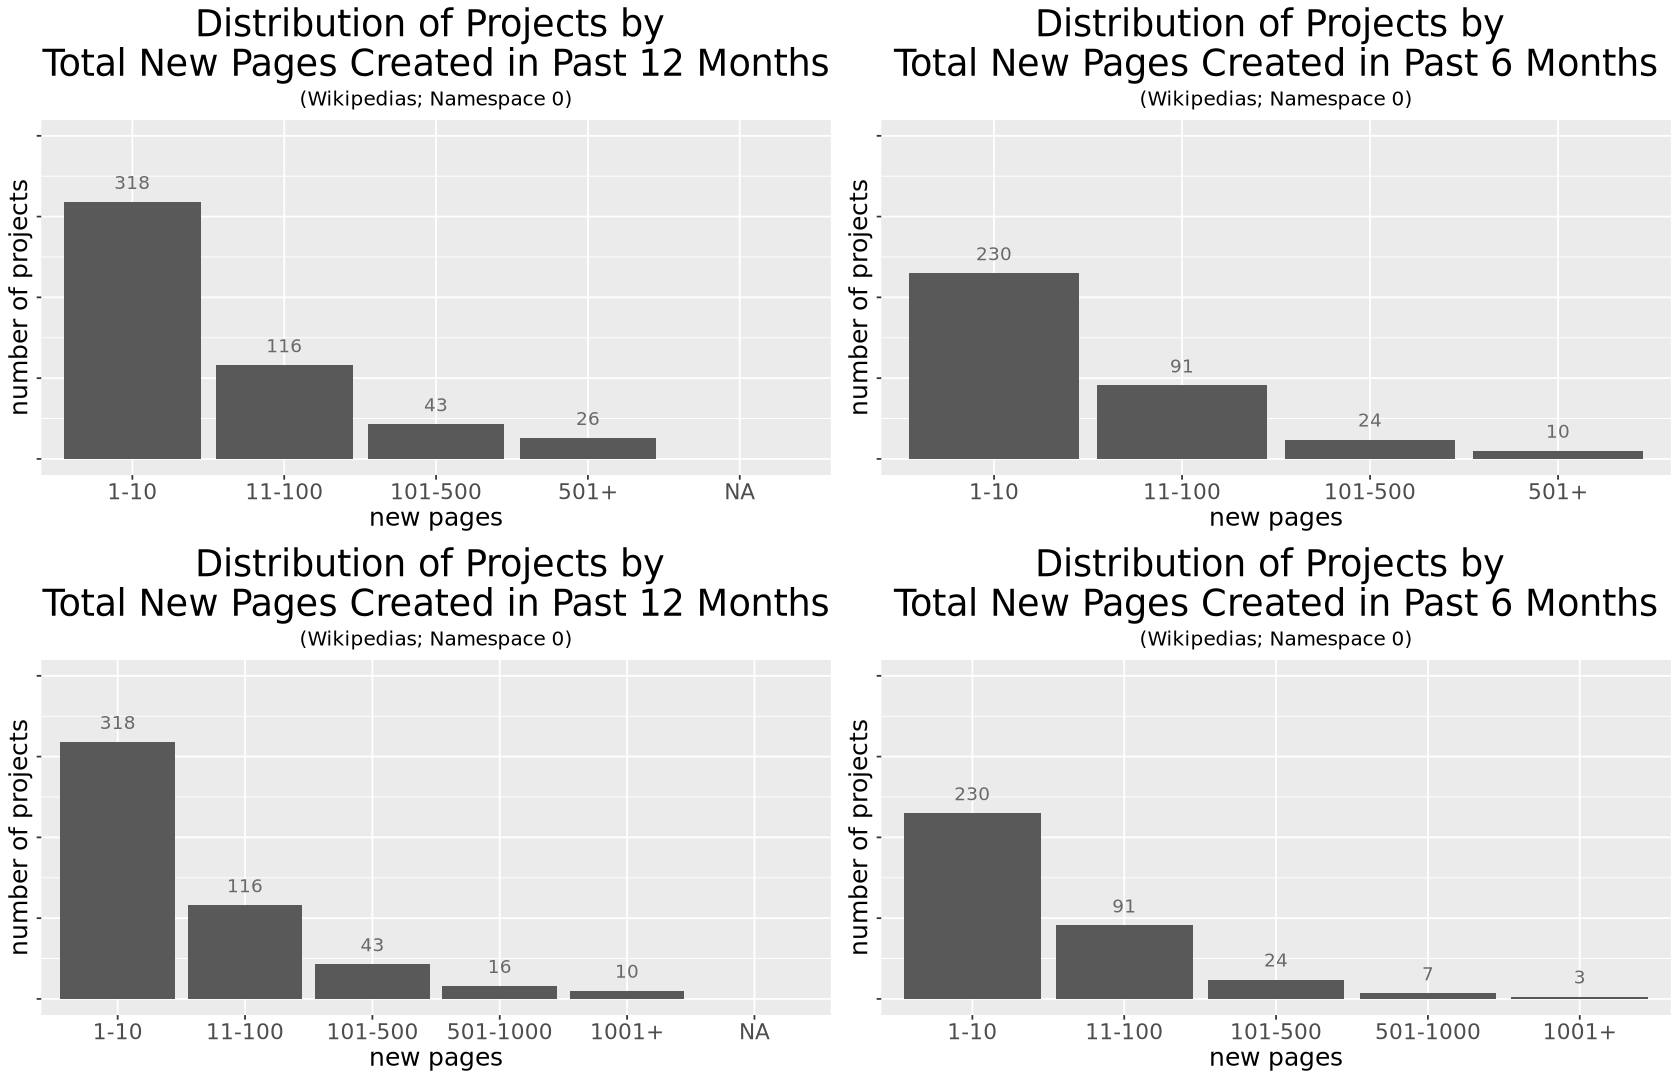

In [25]:
# Plots: total edits past 12 months

p1_4bin <- dfpm_past_year %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 12 Months", subtitle="(Wikipedias; Namespace 0)")+
 xlab("new pages") + ylab("number of projects") +
 ylim(0,400)

p1_5bin <- dfpm_past_year %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 12 Months", subtitle="(Wikipedias; Namespace 0)")+
 xlab("new pages") + ylab("number of projects") +
 ylim(0,400)


# Plots: total edits past 6 months

p2_4bin <- dfpm_past_6m %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 6 Months", subtitle="(Wikipedias; Namespace 0)")+
 xlab("new pages") + ylab("number of projects") +
 ylim(0,400)

p2_5bin <- dfpm_past_6m %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 6 Months", subtitle="(Wikipedias; Namespace 0)")+
 xlab("new pages") + ylab("number of projects") +
 ylim(0,400)

# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=9)
gridExtra::grid.arrange(p1_4bin, p2_4bin, p1_5bin, p2_5bin, ncol = 2) 

**New page creation in namespaces 0, 1, 10, 11, 14, 15, 828, 829**

In [26]:
# Aggregate namespaces
dfpm <- dfpm_import %>%
 dplyr::group_by(prefix, year, month) %>%
 dplyr::summarise(page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'prefix', 'year'. You can override using
the `.groups` argument.


In [27]:
# Define edit_dt
dfpm <- dfpm %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [28]:
# Filter for past year & sum
dfpm_past_year <- dfpm %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, page_creation_count) %>%
 spread(., key="edit_dt", value="page_creation_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="page_creation_count", `2023-07-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(page_creation_count = replace_na(page_creation_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfpm_past_6m <- dfpm %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, page_creation_count) %>%
 spread(., key="edit_dt", value="page_creation_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="page_creation_count", `2024-01-01`:`2024-06-01`) %>% # <--- HERE: DATE RANGE 
 mutate(page_creation_count = replace_na(page_creation_count, 0)) %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::summarise(sum_page_creation_count=sum(page_creation_count)) %>%
 dplyr::ungroup()

In [29]:
# Buckets: page creation past 12 months
dfpm_past_year$buckets4 <- NA
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>0 & dfpm_past_year$sum_page_creation_count<=10] <- "1-10"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>10 & dfpm_past_year$sum_page_creation_count<=100] <- "11-100"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>100 & dfpm_past_year$sum_page_creation_count<=500] <- "101-500"
dfpm_past_year$buckets4[dfpm_past_year$sum_page_creation_count>500] <- "501+"
dfpm_past_year$buckets4 <- factor(dfpm_past_year$buckets4,
                                levels = c("1-10", "11-100", "101-500", "501+"))

dfpm_past_year$buckets5 <- NA
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>0 & dfpm_past_year$sum_page_creation_count<=10] <- "1-10"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>10 & dfpm_past_year$sum_page_creation_count<=100] <- "11-100"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>100 & dfpm_past_year$sum_page_creation_count<=500] <- "101-500"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>500 & dfpm_past_year$sum_page_creation_count<=1000] <- "501-1000"
dfpm_past_year$buckets5[dfpm_past_year$sum_page_creation_count>1000] <- "1001+"
dfpm_past_year$buckets5 <- factor(dfpm_past_year$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))


# Buckets: page creation past 6 months
dfpm_past_6m$buckets4 <- NA
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>0 & dfpm_past_6m$sum_page_creation_count<=10] <- "1-10"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>10 & dfpm_past_6m$sum_page_creation_count<=100] <- "11-100"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>100 & dfpm_past_6m$sum_page_creation_count<=500] <- "101-500"
dfpm_past_6m$buckets4[dfpm_past_6m$sum_page_creation_count>500] <- "501+"
dfpm_past_6m$buckets4 <- factor(dfpm_past_6m$buckets4,
                                levels = c("1-10", "11-100", "101-500", "501+"))

dfpm_past_6m$buckets5 <- NA
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>0 & dfpm_past_6m$sum_page_creation_count<=10] <- "1-10"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>10 & dfpm_past_6m$sum_page_creation_count<=100] <- "11-100"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>100 & dfpm_past_6m$sum_page_creation_count<=500] <- "101-500"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>500 & dfpm_past_6m$sum_page_creation_count<=1000] <- "501-1000"
dfpm_past_6m$buckets5[dfpm_past_6m$sum_page_creation_count>1000] <- "1001+"
dfpm_past_6m$buckets5 <- factor(dfpm_past_6m$buckets5,
                                levels = c("1-10", "11-100", "101-500", "501-1000", "1001+"))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


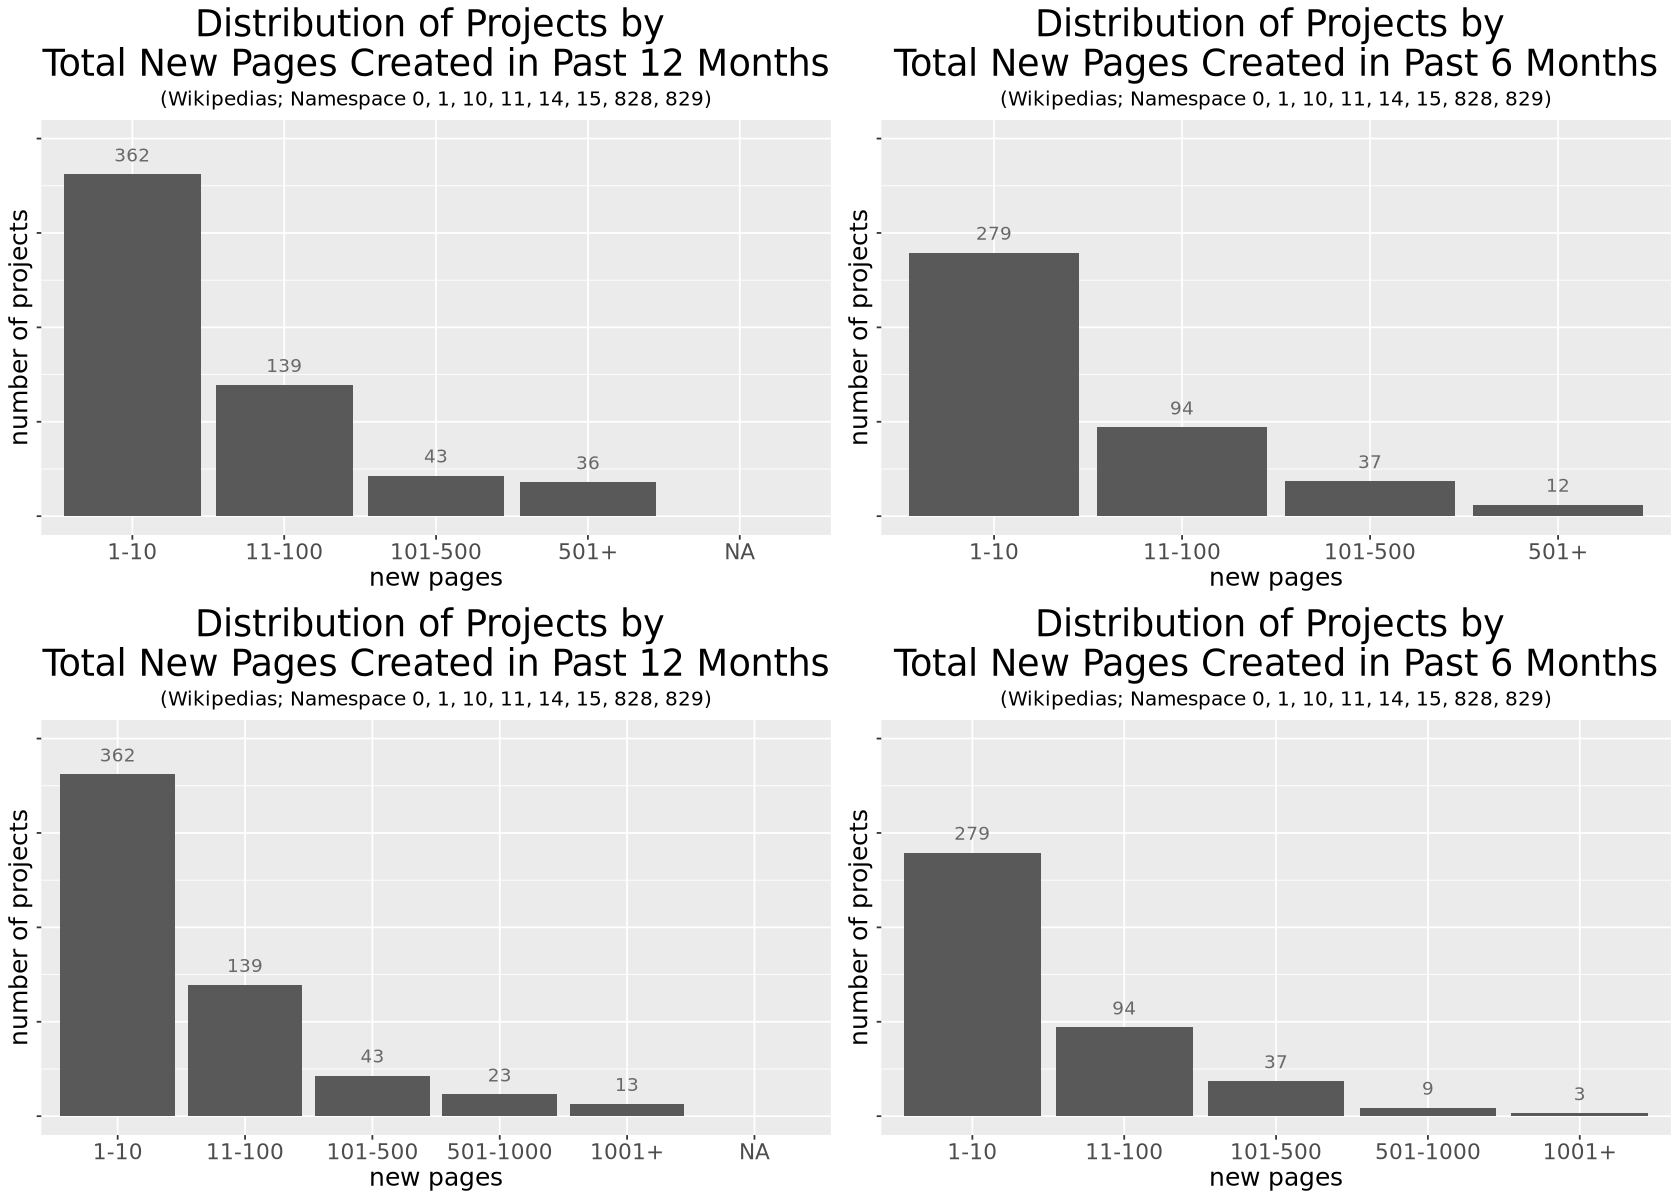

In [30]:
# Plots: total edits past 12 months

p1_4bin <- dfpm_past_year %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
  theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("new pages") +
 ylab("number of projects") +
 ylim(0,400)

p1_5bin <- dfpm_past_year %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
  theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("new pages") +
 ylab("number of projects") +
 ylim(0,400)


# Plots: total edits past 6 months

p2_4bin <- dfpm_past_6m %>% 
 ggplot(aes(x=buckets4)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("new pages") +
 ylab("number of projects") +
 ylim(0,400)

p2_5bin <- dfpm_past_6m %>% 
 ggplot(aes(x=buckets5)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nTotal New Pages Created in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")+
 xlab("new pages") +
 ylab("number of projects") +
 ylim(0,400)


# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=10)
gridExtra::grid.arrange(p1_4bin, p2_4bin, p1_5bin, p2_5bin, ncol = 2) 

# Count of editors with at least 1 edit

In [31]:
# Define edit_dt
dfmee <- dfmee %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [32]:
# Filter for past year & sum
dfmee_past_year <- dfmee %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Calculate sum of edits
 dplyr::group_by(prefix, event_user_text) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfmee_past_6m <- dfmee %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Calculate sum of edits
 dplyr::group_by(prefix, event_user_text) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'prefix'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'prefix'. You can override using the
`.groups` argument.


In [33]:
# Classify amt of edits for past 12 months
dfmee_past_year <- dfmee_past_year %>%
 dplyr::mutate(editor_with_1_or_more = ifelse(sum_edits_count>=1, 1, 0)) %>%
 dplyr::group_by(prefix) %>%
 dplyr::summarise(n_editors_with_1_or_more=sum(editor_with_1_or_more))

# Classify amt of edits for past 12 months
dfmee_past_6m <- dfmee_past_6m %>%
 dplyr::mutate(editor_with_1_or_more = ifelse(sum_edits_count>=1, 1, 0)) %>%
 dplyr::group_by(prefix) %>%
 dplyr::summarise(n_editors_with_1_or_more=sum(editor_with_1_or_more))

Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


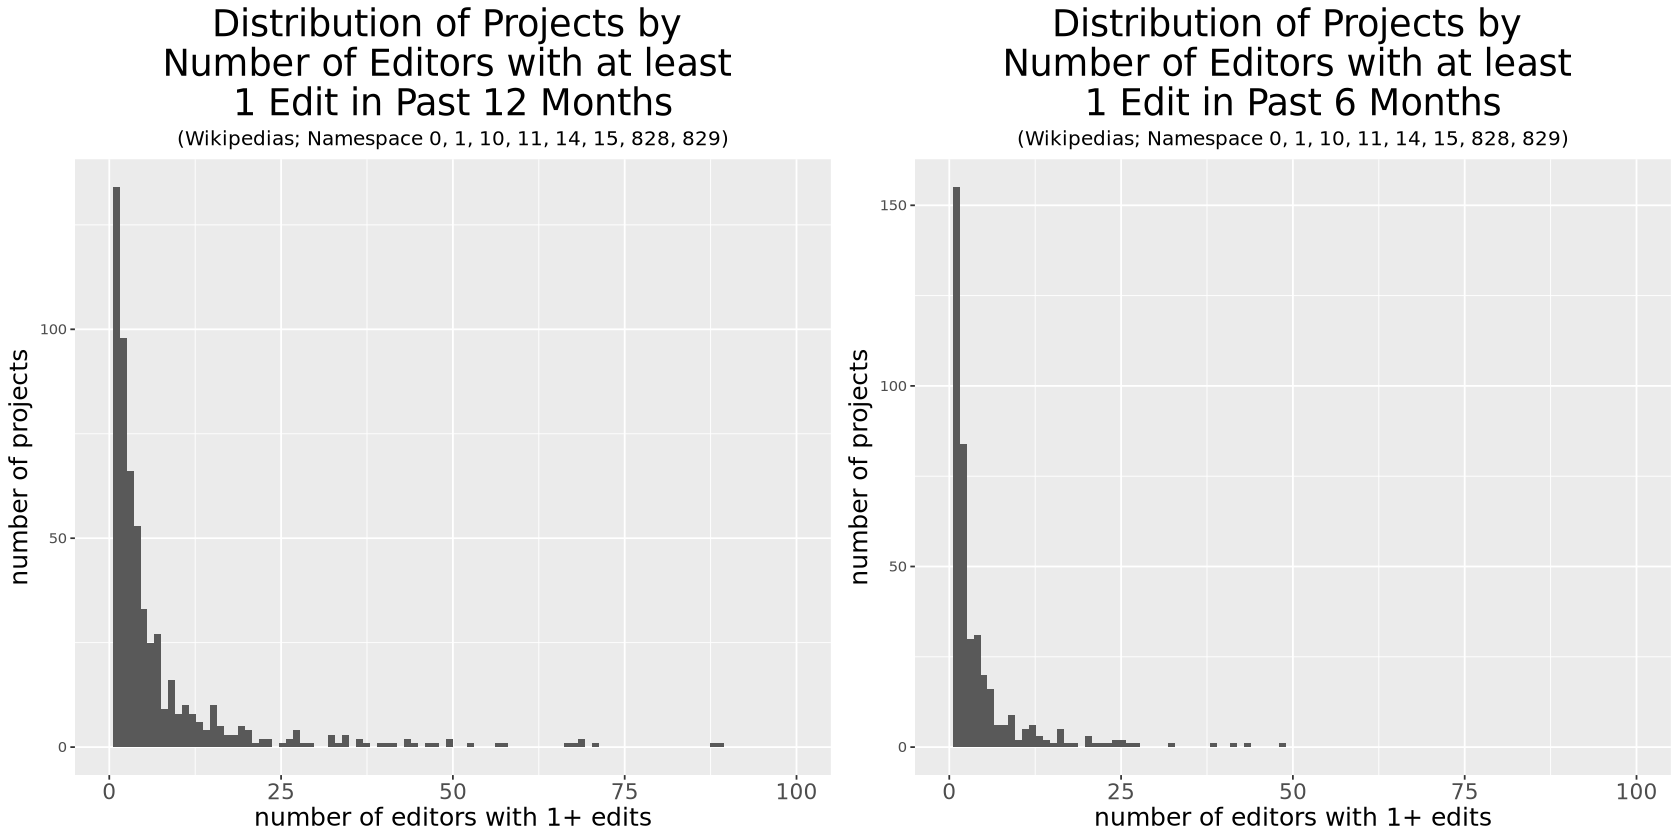

In [34]:
options(repr.plot.width=8, repr.plot.height=8)

# Plot: total edits past 12 months ---- 1 or more edits
p1 <- dfmee_past_year %>% 
 ggplot(aes(x=n_editors_with_1_or_more)) +
 geom_histogram(bins=100) +
# geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
  theme(axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nNumber of Editors with at least \n1 Edit in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 1+ edits") +
 ylab("number of projects") +
 xlim(0,100)

# Plot: total edits past 6 months ---- 1 or more edits
p2 <- dfmee_past_6m %>% 
 ggplot(aes(x=n_editors_with_1_or_more)) +
 geom_histogram(bins=100) +
# geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
  theme(axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nNumber of Editors with at least \n1 Edit in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 1+ edits") +
 ylab("number of projects") +
 xlim(0,100)


# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=7)
gridExtra::grid.arrange(p1, p2, ncol = 2) 

In [35]:
# Buckets: past 12 months
dfmee_past_year$buckets <- NA
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more==0] <- "0"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more==1] <- "1"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more>1 & dfmee_past_year$n_editors_with_1_or_more<=6] <- "2-5"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more>5 & dfmee_past_year$n_editors_with_1_or_more<=10] <- "6-10"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more>10 & dfmee_past_year$n_editors_with_1_or_more<=16] <- "11-15"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_1_or_more>=15] <- "16+"
dfmee_past_year$buckets <- factor(dfmee_past_year$buckets, 
                                  levels = c("0", "1", "2-5", "6-10", "11-15", "16+"))

# Buckets: past 6 months
dfmee_past_6m$buckets <- NA
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more==0] <- "0"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more==1] <- "1"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more>1 & dfmee_past_6m$n_editors_with_1_or_more<=6] <- "2-5"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more>5 & dfmee_past_6m$n_editors_with_1_or_more<=10] <- "6-10"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more>10 & dfmee_past_6m$n_editors_with_1_or_more<=16] <- "11-15"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_1_or_more>=15] <- "16+"
dfmee_past_6m$buckets <- factor(dfmee_past_6m$buckets, 
                                  levels = c("0", "1", "2-5", "6-10", "11-15",  "16+"))

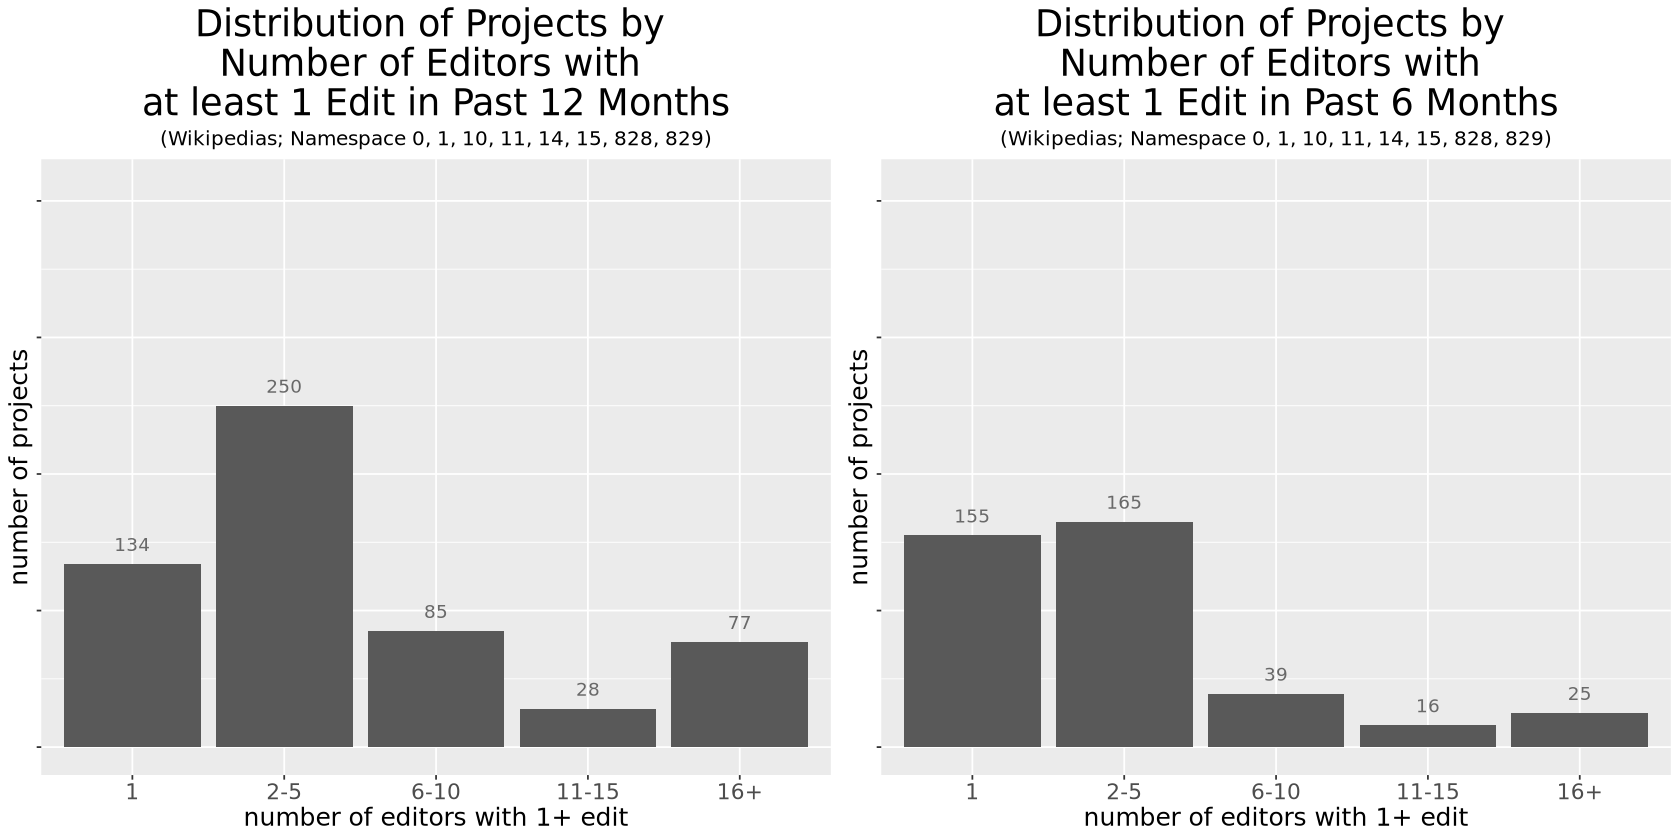

In [36]:
# Plot: total edits past 12 months
p1 <- dfmee_past_year %>% 
 ggplot(aes(x=buckets)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nNumber of Editors with \nat least 1 Edit in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")  +
 xlab("number of editors with 1+ edit") + ylab("number of projects") +
 ylim(0, 410)

# Plot: total edits past 6 months
p2 <- dfmee_past_6m %>% 
 ggplot(aes(x=buckets)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 theme(axis.text.y=element_blank(), axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nNumber of Editors with \nat least 1 Edit in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 1+ edit") + ylab("number of projects") +
 ylim(0, 410)

# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=7)
gridExtra::grid.arrange(p1, p2, ncol = 2) 

# Count editors with at least 5 edits

In [37]:
# Define edit_dt
dfmee <- dfmee %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

In [38]:
# Filter for past year & sum
dfmee_past_year <- dfmee %>% 
 filter(edit_dt <= "2024-07-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Calculate sum of edits
 dplyr::group_by(prefix, event_user_text) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()

# Filter for past 6 months & sum
dfmee_past_6m <- dfmee %>% 
 filter(edit_dt >= "2024-01-01" & edit_dt <= "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Calculate sum of edits
 dplyr::group_by(prefix, event_user_text) %>%
 dplyr::summarise(sum_edits_count=sum(edits_count)) %>%
 dplyr::ungroup()


`summarise()` has grouped output by 'prefix'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'prefix'. You can override using the
`.groups` argument.


In [39]:
# Classify amt of edits for past 12 months
dfmee_past_year <- dfmee_past_year %>%
 dplyr::mutate(editor_with_5_or_more = ifelse(sum_edits_count>=5, 1, 0)) %>%
 dplyr::group_by(prefix) %>%
 dplyr::summarise(n_editors_with_5_or_more=sum(editor_with_5_or_more))

# Classify amt of edits for past 12 months
dfmee_past_6m <- dfmee_past_6m %>%
 dplyr::mutate(editor_with_5_or_more = ifelse(sum_edits_count>=5, 1, 0)) %>%
 dplyr::group_by(prefix) %>%
 dplyr::summarise(n_editors_with_5_or_more=sum(editor_with_5_or_more))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


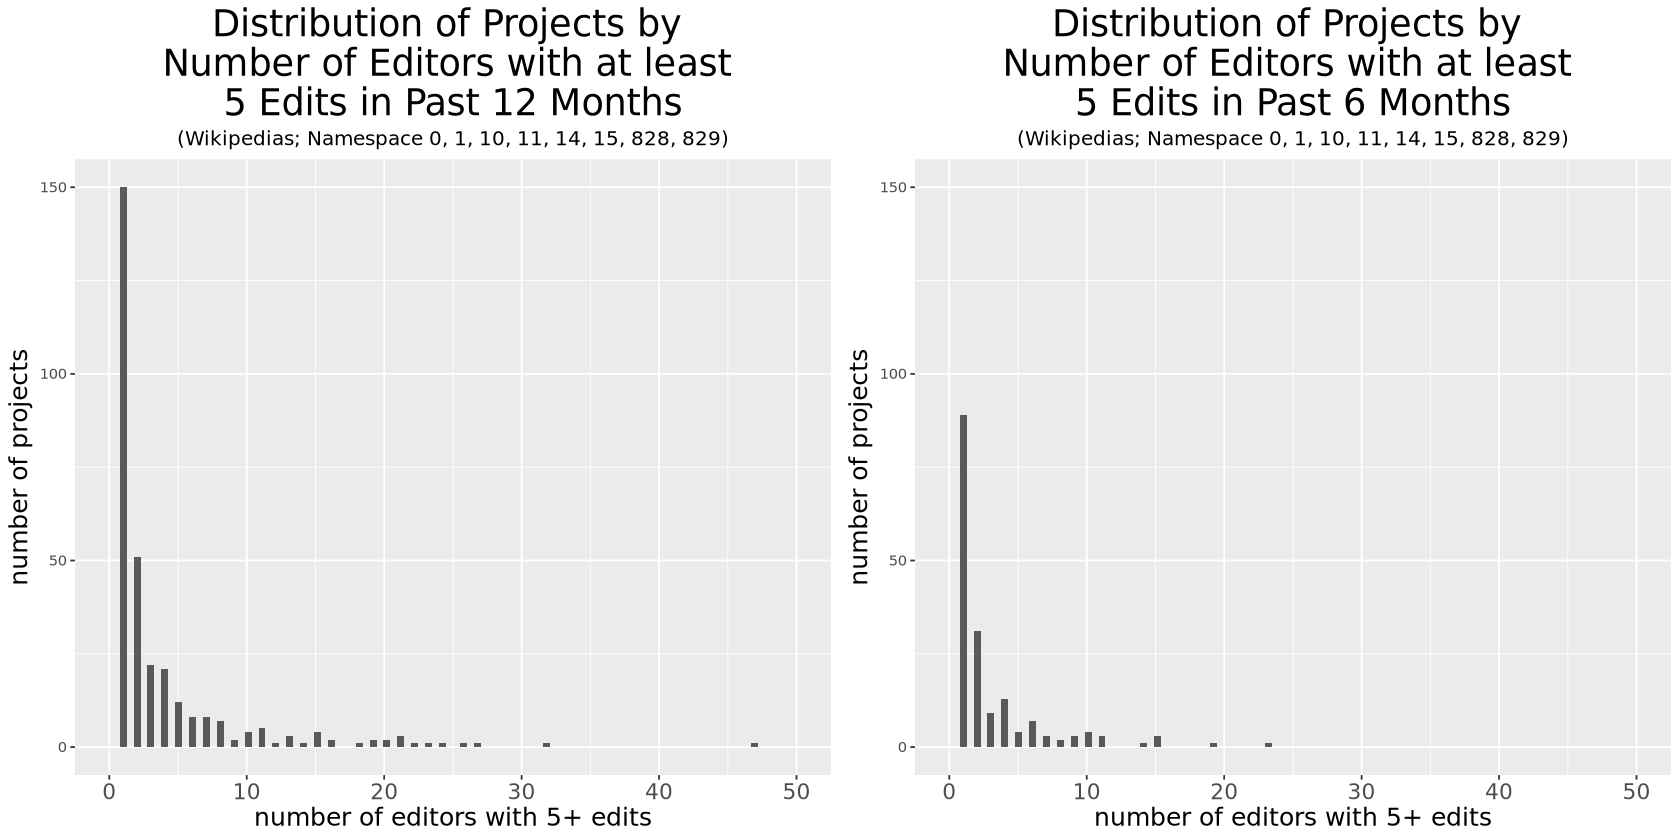

In [40]:
options(repr.plot.width=8, repr.plot.height=8)

# Plot: total edits past 12 months ---- 5 or more edits
p1 <- dfmee_past_year %>% 
 ggplot(aes(x=n_editors_with_5_or_more)) +
 geom_histogram(bins=100) +
  theme( axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nNumber of Editors with at least \n5 Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 5+ edits") +
 ylab("number of projects") +
 xlim(0,50)+
 ylim(0,150)

# Plot: total edits past 6 months ---- 5 or more edits
p2 <- dfmee_past_6m %>% 
 ggplot(aes(x=n_editors_with_5_or_more)) +
 geom_histogram(bins=100) +
  theme(axis.text.x=element_text(size=13), plot.subtitle=element_text(size=12, hjust=0.5),
       axis.title=element_text(size=15), plot.title=element_text(size=22, hjust=0.5)) +
 labs(title="Distribution of Projects by \nNumber of Editors with at least \n5 Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 5+ edits") +
 ylab("number of projects") +
 xlim(0,50) +
 ylim(0,150)


# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=7)
gridExtra::grid.arrange(p1, p2, ncol = 2) 

In [41]:
# Buckets: past 12 months
dfmee_past_year$buckets <- NA
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more==0] <- "0"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more==1] <- "1"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more>1 & dfmee_past_year$n_editors_with_5_or_more<=6] <- "2-5"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more>5 & dfmee_past_year$n_editors_with_5_or_more<=10] <- "6-10"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more>10 & dfmee_past_year$n_editors_with_5_or_more<=16] <- "11-15"
dfmee_past_year$buckets[dfmee_past_year$n_editors_with_5_or_more>15] <- "16+"
dfmee_past_year$buckets <- factor(dfmee_past_year$buckets, 
                                  levels = c("0", "1", "2-5", "6-10", "11-15", "16+"))

# Buckets: past 6 months
dfmee_past_6m$buckets <- NA
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more==0] <- "0"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more==1] <- "1"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more>1 & dfmee_past_6m$n_editors_with_5_or_more<=6] <- "2-5"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more>5 & dfmee_past_6m$n_editors_with_5_or_more<=10] <- "6-10"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more>10 & dfmee_past_6m$n_editors_with_5_or_more<=16] <- "11-15"
dfmee_past_6m$buckets[dfmee_past_6m$n_editors_with_5_or_more>=16] <- "16+"
dfmee_past_6m$buckets <- factor(dfmee_past_6m$buckets, 
                                  levels = c("0", "1", "2-5", "6-10", "11-15", "16+"))

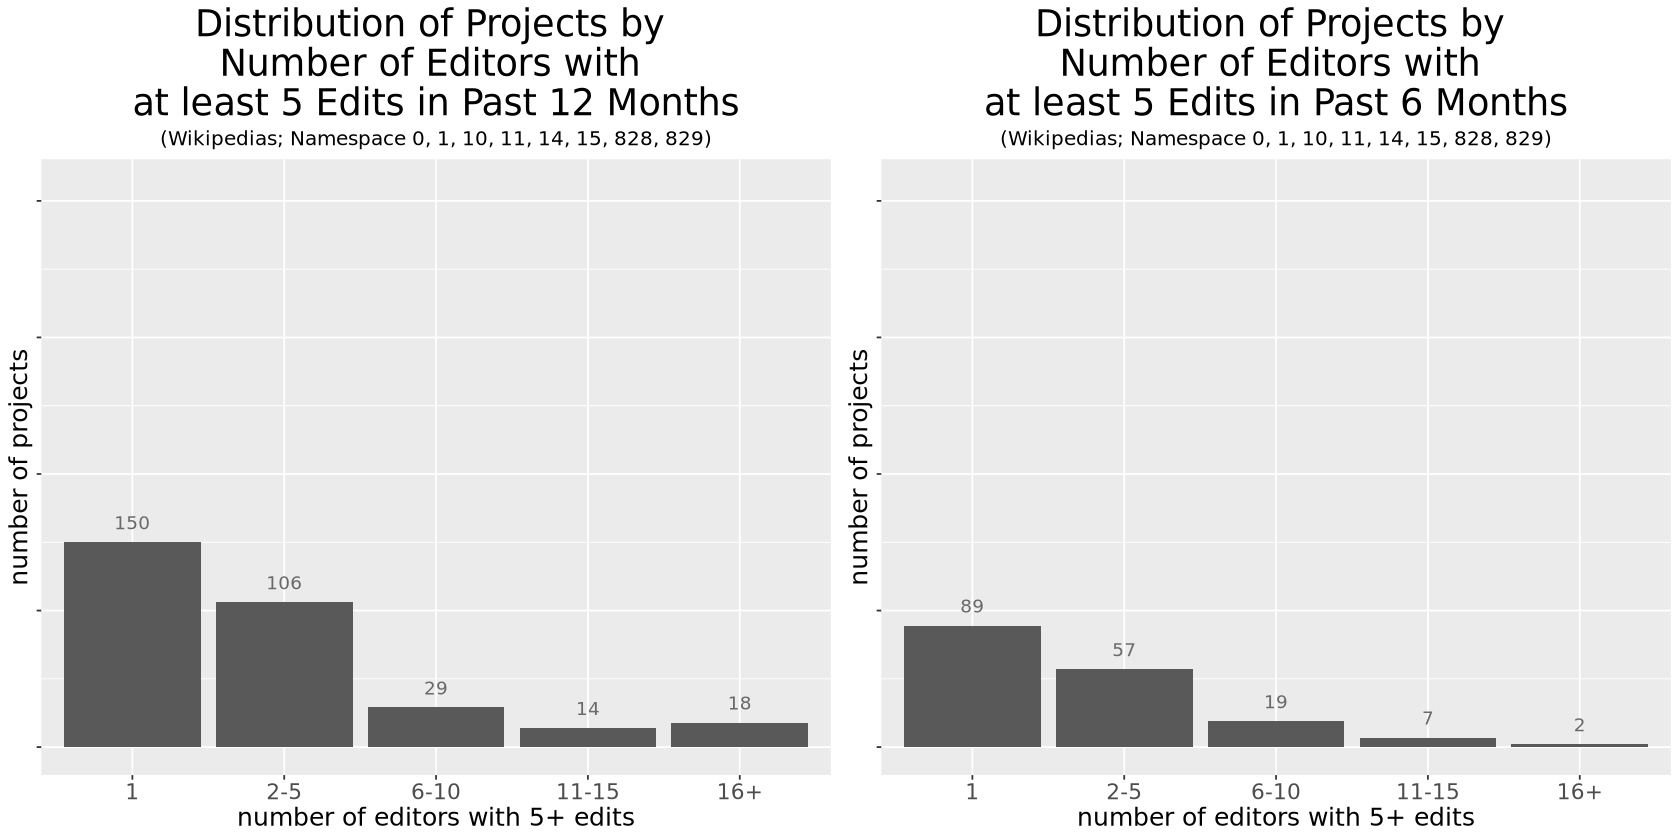

In [42]:
# Plot: total edits past 12 months
p1 <- dfmee_past_year %>% 
 filter(buckets!="0") %>% # <--- exclude projects with 0 editors making 5+ edits
 ggplot(aes(x=buckets)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nNumber of Editors with \nat least 5 Edits in Past 12 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)")  +
 xlab("number of editors with 5+ edits") + ylab("number of projects") +
 ylim(0, 410)


# Plot: total edits past 6 months
p2 <- dfmee_past_6m %>% 
 filter(buckets!="0") %>% # <--- exclude projects with 0 editors making 5+ edits
 ggplot(aes(x=buckets)) +
 geom_bar(stat="count") +
 geom_text(aes(label = after_stat(count)), stat = "count", vjust = -1, colour = "dimgray") +
 my_theme() +
 labs(title="Distribution of Projects by \nNumber of Editors with \nat least 5 Edits in Past 6 Months", subtitle="(Wikipedias; Namespace 0, 1, 10, 11, 14, 15, 828, 829)") +
 xlab("number of editors with 5+ edits") + ylab("number of projects") +
 ylim(0, 410)



# Plot side-by-side
options(repr.plot.width=14, repr.plot.height=7)
gridExtra::grid.arrange(p1, p2, ncol = 2) 